# DataJoint configuration

## Setup - Working Directory

To run the workflow, we need to properly set up the DataJoint configuration. The configuration can be saved in a local directory as `dj_local_conf.json` or at your root directory as a hidden file. This notebook walks you through the setup process.

**The configuration only needs to be set up once**, if you have gone through the configuration before, directly go to [02-workflow-structure](02-workflow-structure-optional.ipynb).

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
import datajoint as dj

In [ ]:
import datajoint as dj

## Setup - Credentials

Now let's set up the host, user and password in the `dj.config` global variable

In [3]:
import getpass

dj.config["database.host"] = "{YOUR_HOST}"  # CodeBook users should omit this
dj.config["database.user"] = "{YOUR_USERNAME}"
dj.config["database.password"] = getpass.getpass()  # enter the password securely

You should be able to connect to the database at this stage.

In [4]:
dj.conn()

## Setup - `dj.config['custom']`

The major component of the current workflow is the [DataJoint Calcium Imaging Element](https://github.com/datajoint/element-array-ephys). Calcium Imaging Element requires configurations in the field `custom` in `dj.config`:

### Database prefix

Giving a prefix to schema could help on the configuration of privilege settings. For example, if we set prefix `neuro_`, every schema created with the current workflow will start with `neuro_`, e.g. `neuro_lab`, `neuro_subject`, `neuro_scan` etc.

The prefix could be configured in `dj.config` as follows. CodeBook users should keep their username as the prefix for schema declaration permissions.

In [5]:
username_as_prefix = dj.config["database.user"] + "_"
dj.config["custom"] = {"database.prefix": username_as_prefix}

### Root directories for raw/processed data

`imaging_root_data_dir` field indicates the root directory for
+ The **raw data** from ScanImage or Scanbox (e.g. `*.tif`)
+ The processed results from Suite2p or CaImAn (e.g. `F.npy`). 

This can be specific to each machine. The root path typically **does not** contain information of subjects or sessions, all data from subjects/sessions should be subdirectories in the root path.

+ In the example dataset downloaded with [these instructions](00-data-download-optional.ipynb), `/tmp/test_data` will be the root. 
+ For CodeBook users, the root is `/home/inbox/0_1_0a2/`

```
subject3
└── 210107_run00_orientation_8dir
    ├── run00_orientation_8dir_000_000.mat
    ├── run00_orientation_8dir_000_000.sbx
    └── suite2p
        ├── combined # same as plane0, plane1, plane2, and plane3
        │   ├── F.npy
        │   ├── Fneu.npy
        │   ├── iscell.npy
        │   ├── ops.npy
        │   ├── spks.npy
        │   └── stat.npy
        └── run.log
```

If using our example dataset, downloaded with this notebook [00-data-download](00-data-download-optional.ipynb), the root directory will be:

In [8]:
dj.config["custom"]["imaging_root_data_dir"] = "/tmp/example_data"  # local download
dj.config["custom"]["imaging_root_data_dir"] = "/home/inbox/0_1_0a2/"  # on CodeBook

In [9]:
dj.config

## Save configuration

We could save this as a file, either as a local json file, or a global file. Local configuration file is saved as `dj_local_conf.json` in current directory, which is great for project-specific settings.

For first-time and CodeBook users, we recommend saving globally. This will create a hidden configuration file saved in your root directory, loaded whenever there is no local version to override it.

In [ ]:
# dj.config.save_local()
dj.config.save_global()

## Next Step

After the configuration, we will be able to run through the workflow with the [02-workflow-structure](02-workflow-structure-optional.ipynb) notebook.

# Introduction to the workflow structure

This notebook gives a brief overview of the workflow structure and introduces some useful DataJoint tools to facilitate the exploration.

+ DataJoint needs to be pre-configured before running this notebook, if you haven't set up the configuration, refer to notebook [01-configure](01-configure.ipynb).

+ If you are familiar with DataJoint and the workflow structure, proceed to the next notebook [03-process](03-process.ipynb) directly to run the workflow.

+ For a more thorough introduction of DataJoint functions, please visit our [general tutorial site](https://playground.datajoint.io)

To load the local configuration, we will change the directory to the package root.

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

## Schemas and tables

+ The current workflow is composed of multiple database schemas, each of them corresponds to a module within `workflow_calcium_imaging.pipeline`

In [2]:
import datajoint as dj
from workflow_calcium_imaging.pipeline import lab, subject, session, scan, imaging

Connecting user1@127.0.0.1:3306


+ Each module contains a schema object that enables interaction with the schema in the database.

In [3]:
imaging.schema

Schema `neuro_imaging`

+ The table classes in the module corresponds to a table in the schema in the database.

In [4]:
# preview columns and contents in a table
imaging.Processing()

*subject    *session_datet *scan_id    *paramset_idx  processing_tim package_versio
+---------+ +------------+ +---------+ +------------+ +------------+ +------------+

 (Total: 0)

+ By importing the modules for the first time, the schemas and tables will be created inside the database.

+ Once created, importing modules will not create schemas and tables again, but the existing schemas/tables can be accessed and manipulated by the modules.

## DataJoint tools to explore schemas and tables

+ `dj.list_schemas()`: list all schemas a user has access to in the current database

In [5]:
dj.list_schemas()

+ `dj.Diagram()`: plot tables and dependencies in a schema. 

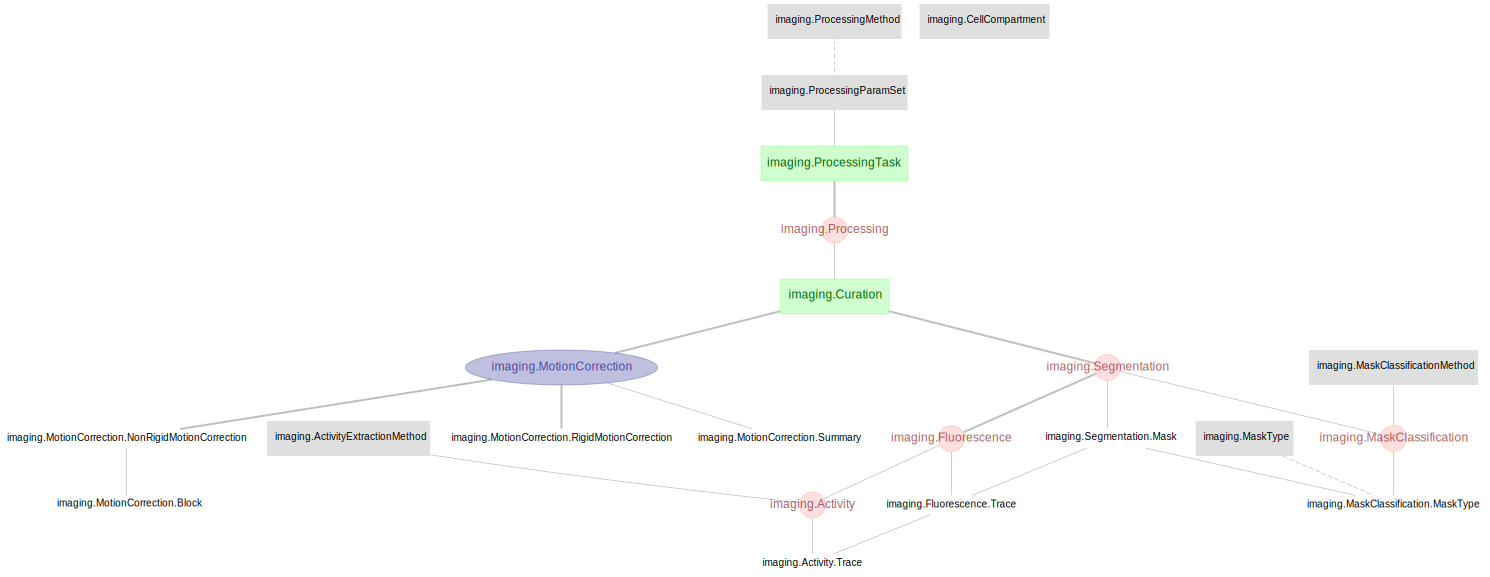

In [6]:
# plot diagram for all tables in a schema
dj.Diagram(imaging)

**Table tiers**: 

Manual table: green box, manually inserted table, expect new entries daily, e.g. Subject, ProbeInsertion.  
Lookup table: gray box, pre inserted table, commonly used for general facts or parameters. e.g. Strain, ClusteringMethod, ClusteringParamSet.  
Imported table: blue oval, auto-processing table, the processing depends on the importing of external files. e.g. process of Clustering requires output files from kilosort2.  
Computed table: red circle, auto-processing table, the processing does not depend on files external to the database, commonly used for     
Part table: plain text, as an appendix to the master table, all the part entries of a given master entry represent a intact set of the master entry. e.g. Unit of a CuratedClustering.

**Dependencies**:  

One-to-one primary: thick solid line, share the exact same primary key, meaning the child table inherits all the primary key fields from the parent table as its own primary key.     
One-to-many primary: thin solid line, inherit the primary key from the parent table, but have additional field(s) as part of the primary key as well
secondary dependency: dashed line, the child table inherits the primary key fields from parent table as its own secondary attribute.

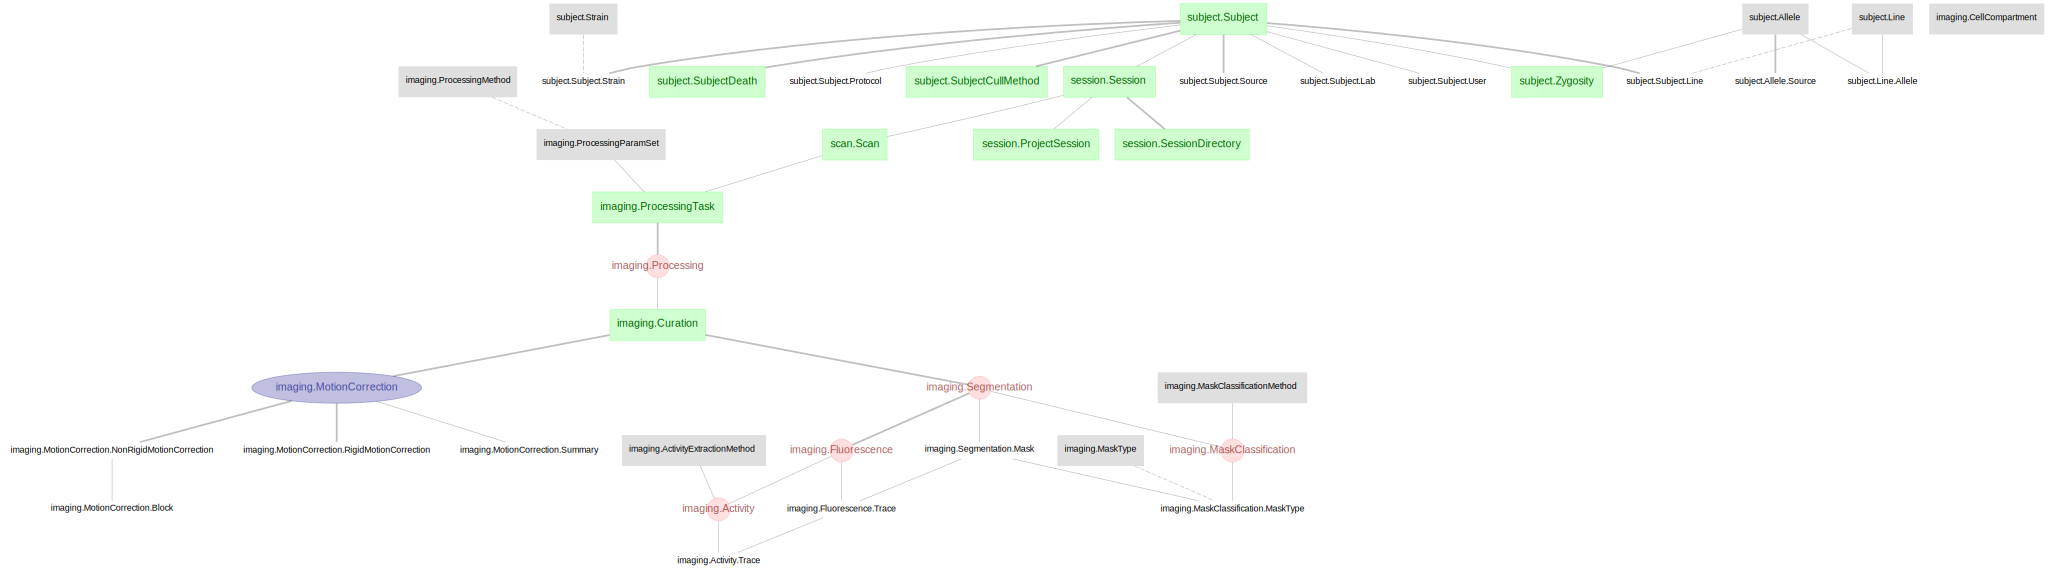

In [7]:
# plot diagram of tables in multiple schemas
dj.Diagram(subject) + dj.Diagram(session) + dj.Diagram(imaging)

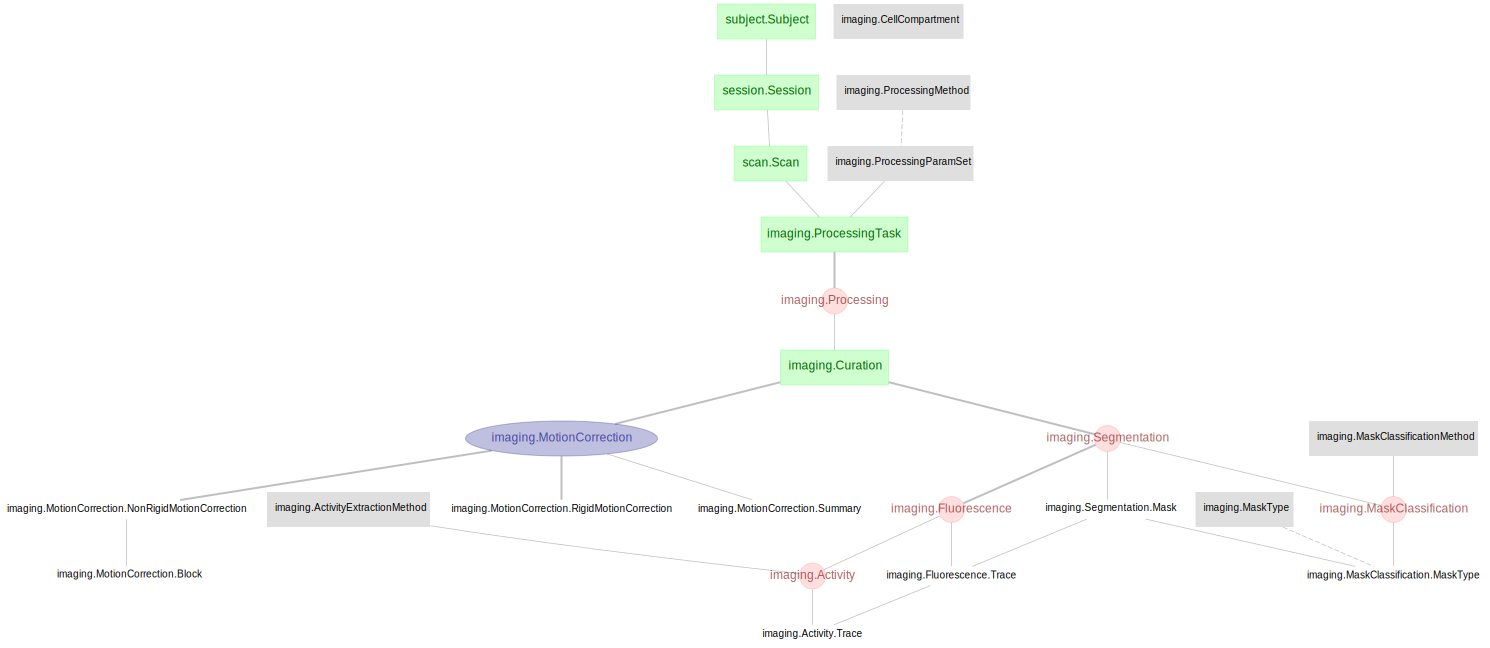

In [8]:
# plot diagram of selected tables and schemas
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(imaging)

+ `describe()`: show table definition with foreign key references.

In [9]:
imaging.Processing.describe();

# Processing Procedure
-> imaging.ProcessingTask
---
processing_time      : datetime                     # time of generation of this set of processed, segmented results
package_version=""   : varchar(16)                  



+ `heading`: show attribute definitions regardless of foreign key references

In [10]:
imaging.Processing.heading

# Processing Procedure
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
scan_id              : int                          # 
paramset_idx         : smallint                     # 
---
processing_time      : datetime                     # time of generation of this set of processed, segmented results
package_version=""   : varchar(16)                  # 

# DataJoint Elements installed in the `workflow-calcium-imaging`

+ [`lab`](https://github.com/datajoint/element-lab): lab management related information, such as Lab, User, Project, Protocol, Source.

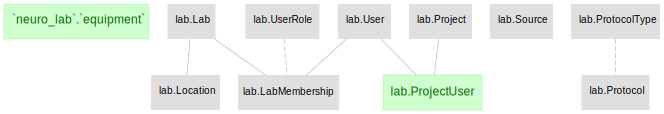

In [11]:
dj.Diagram(lab)

+ [`subject`](https://github.com/datajoint/element-animal): general animal information, User, Genetic background, Death etc.

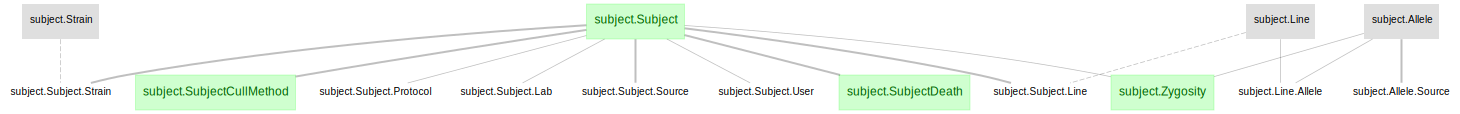

In [12]:
dj.Diagram(subject)

In [13]:
subject.Subject.describe();

# Animal Subject
subject              : varchar(32)                  
---
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



+ [`session`](https://github.com/datajoint/element-session): General information of experimental sessions.

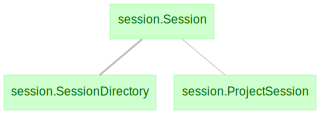

In [14]:
dj.Diagram(session)

In [15]:
session.Session.describe();

-> subject.Subject
session_datetime     : datetime(3)                  



+ [`imaging`](https://github.com/datajoint/element-calcium-imaging): Calcium imaging raw scan and processed data

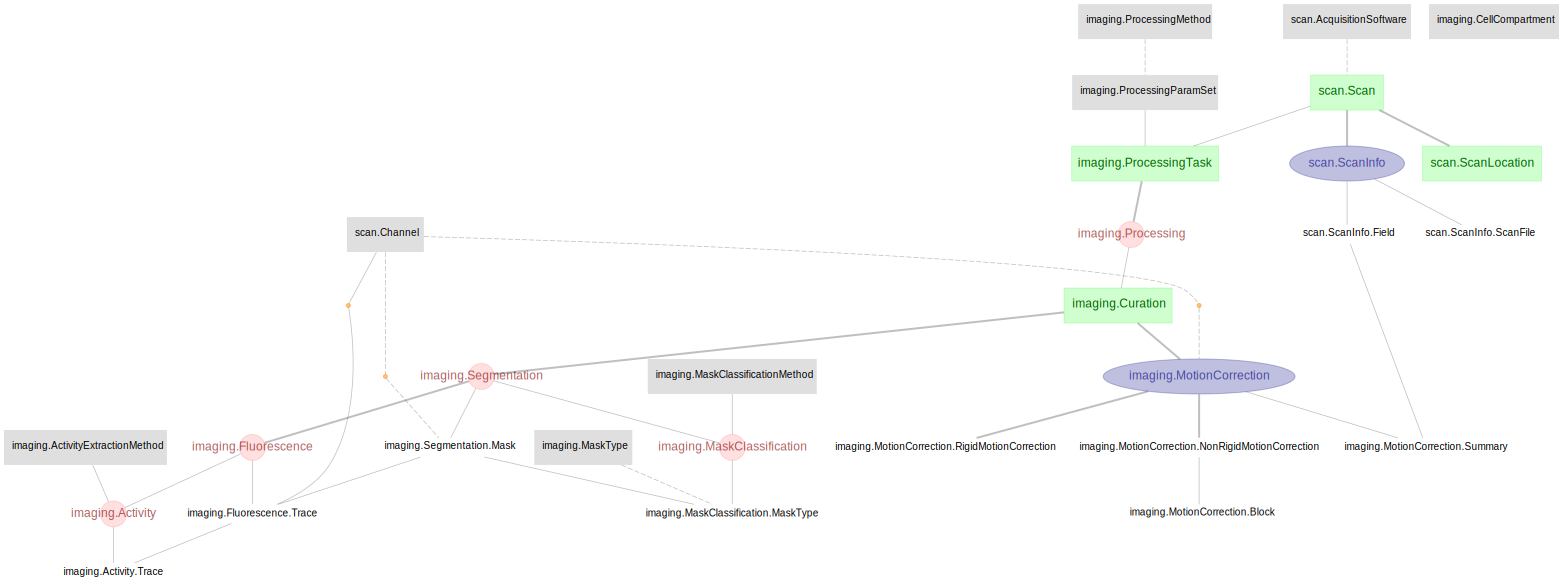

In [16]:
dj.Diagram(scan) + dj.Diagram(imaging)

## Summary and next step

+ This notebook introduced the overall structures of the schemas and tables in the workflow and relevant tools to explore the schema structure and table definitions.

+ In the next notebook [03-process](03-process.ipynb), we will introduce the detailed steps to run through `workflow-calcium-imaging`.

# Interactively run workflow calcium imaging

+ This notebook walks you through the steps in detail to run the `workflow-calcium-imaging`.  

+ The workflow requires the calcium imaging acquired data from ScanImage or Scanbox and processed data from Suite2p or CaImAn.

+ If you haven't configured the paths, refer to [01-configure](01-configure.ipynb).

+ To overview the schema structures, refer to [02-workflow-structure](02-workflow-structure.ipynb).

+ If you need a more automatic approach to run the workflow, refer to [03-automate](03-automate-optional.ipynb).

Let's change the directory to the package root directory to load the local configuration (`dj_local_conf.json`).

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
import numpy as np

## `Pipeline.py`

+ This script `activates` the DataJoint `elements` and declares other required tables.

In [2]:
import datajoint as dj
from workflow_calcium_imaging.pipeline import *

Connecting user1@127.0.0.1:3306


## Schema diagrams

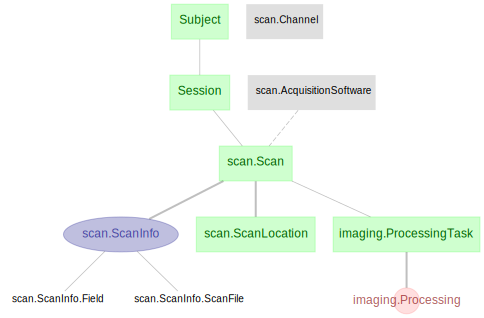

In [3]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan)
    + dj.Diagram(imaging.Processing)
)

## Insert an entry into `subject.Subject`

In [4]:
subject.Subject.heading

# Animal Subject
subject              : varchar(32)                  # 
---
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

In [5]:
subject.Subject.insert1(
    dict(
        subject="subject3",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="Scanbox acquisition. Suite2p processing.",
    )
)

## Insert an entry into `lab.Equipment`

In [6]:
Equipment.insert1(dict(scanner="Scanbox"))

## Insert an entry into `session.Session`

In [7]:
session.Session.describe();

-> Subject
session_datetime     : datetime(3)                  



In [8]:
session.Session.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 

In [9]:
session_key = dict(subject="subject3", session_datetime="2021-04-30 12:22:15.032")

session.Session.insert1(session_key)

session.Session()

*subject     *session_datet
+----------+ +------------+
subject3     2021-04-30 12:
 (Total: 1)

## Insert an entry into `session.SessionDirectory`

+ The `session_dir` is the relative path to the `imaging_root_data_dir` for the given session, in POSIX format with `/`.

+ Instead of a relative path, `session_dir` could be an absolute path but it is not recommended as the absolute path would have to match the `imaging_root_data_dir` in `dj_local_conf.json`.

In [10]:
session.SessionDirectory.describe();

-> Session
---
session_dir          : varchar(256)                 # Path to the data directory for a particular session



In [11]:
session.SessionDirectory.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
---
session_dir          : varchar(256)                 # Path to the data directory for a particular session

In [12]:
session.SessionDirectory.insert1(
    dict(
        subject="subject3",
        session_datetime="2021-04-30 12:22:15.032",
        session_dir="subject3/210107_run00_orientation_8dir",
    )
)

session.SessionDirectory()

*subject     *session_datet session_dir   
+----------+ +------------+ +------------+
subject3     2021-04-30 12: subject3/21010
 (Total: 1)

## Insert an entry into `scan.Scan`

In [13]:
scan.Scan.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
scan_id              : int                          # 
---
scanner              : varchar(32)                  # 
acq_software         : varchar(24)                  # 
scan_notes=""        : varchar(4095)                # free-notes

In [14]:
scan.Scan.insert1(
    dict(
        subject="subject3",
        session_datetime="2021-04-30 12:22:15.032",
        scan_id=0,
        scanner="Scanbox",
        acq_software="Scanbox",
        scan_notes="",
    )
)
scan.Scan()

*subject     *session_datet *scan_id    scanner     acq_software   scan_notes    
+----------+ +------------+ +---------+ +---------+ +------------+ +------------+
subject3     2021-04-30 12: 0           Scanbox     Scanbox                      
 (Total: 1)

## Populate `scan.ScanInfo`

+ This imported table stores information about the acquired image (e.g. image dimensions, file paths, etc.).
+ `populate` automatically calls `make` for every key for which the auto-populated table is missing data.
+ `populate_settings` passes arguments to the `populate` method.
+ `display_progress=True` reports the progress bar

In [15]:
scan.ScanInfo.describe();

# general data about the reso/meso scans, from ScanImage header
-> scan.Scan
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
y                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
z                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : float                        # (Hz) frames per second - Volumetric Scan Rate
bidirectional        : tinyint                      # true = bidirectio

In [16]:
scan.ScanInfo.heading

# general data about the reso/meso scans, from ScanImage header
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
scan_id              : int                          # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
y                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
z                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                

In [17]:
populate_settings = {"display_progress": True}

In [18]:
scan.ScanInfo.populate(**populate_settings)
scan.ScanInfo()

ScanInfo: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]{'scanning_mode': 'bidirectional', 'frame_rate': 7.8125, 'num_frames': 7530, 'num_channels': 1, 'num_planes': 4, 'frame_size': array([512, 796], dtype=uint16), 'num_target_frames': 0, 'num_stored_frames': 30123, 'stage_pos': [0, 0, -311.71], 'stage_angle': 9.65, 'etl_pos': [203, 255, 314, 379], 'filename': 'run00_orientation_8dir_000_000.sbx', 'resonant_freq': 8000, 'scanbox_version': 3, 'records_per_buffer': 256, 'magnification': 1.7, 'um_per_pixel_x': nan, 'um_per_pixel_y': nan, 'objective': 'Nikon_16x_dlr', 'messages': array([], dtype=object), 'event_id': array([], dtype=uint8), 'usernotes': array([], dtype='<U1'), 'ballmotion': array([], dtype='<U1')}



*subject     *session_datet *scan_id    nfields     nchannels     ndepths     nframes     nrois     x       y       z           fps        bidirectional  usecs_per_line fill_fraction 
+----------+ +------------+ +---------+ +---------+ +-----------+ +---------+ +---------+ +-------+ +-----+ +-----+ +---------+ +--------+ +------------+ +------------+ +------------+
subject3     2021-04-30 12: 0           4           1             4           7530        0         0.0     0.0     -311.71     7.8125     0              nan            nan           
 (Total: 1)

## (Optional) Insert a new entry into `imaging.ProcessingParamSet` for Suite2p or CaImAn

+ Define and insert the parameters that will be used for the Suite2p or CaImAn processing.

+ This step is not needed if you are using an existing ProcessingParamSet.

### Define Suite2p parameters

In [19]:
params_suite2p = {
    "look_one_level_down": 0.0,
    "fast_disk": [],
    "delete_bin": False,
    "mesoscan": False,
    "h5py": [],
    "h5py_key": "data",
    "save_path0": [],
    "subfolders": [],
    "nplanes": 1,
    "nchannels": 1,
    "functional_chan": 1,
    "tau": 1.0,
    "fs": 10.0,
    "force_sktiff": False,
    "preclassify": 0.0,
    "save_mat": False,
    "combined": True,
    "aspect": 1.0,
    "do_bidiphase": False,
    "bidiphase": 0.0,
    "do_registration": True,
    "keep_movie_raw": False,
    "nimg_init": 300,
    "batch_size": 500,
    "maxregshift": 0.1,
    "align_by_chan": 1,
    "reg_tif": False,
    "reg_tif_chan2": False,
    "subpixel": 10,
    "smooth_sigma": 1.15,
    "th_badframes": 1.0,
    "pad_fft": False,
    "nonrigid": True,
    "block_size": [128, 128],
    "snr_thresh": 1.2,
    "maxregshiftNR": 5.0,
    "1Preg": False,
    "spatial_hp": 50.0,
    "pre_smooth": 2.0,
    "spatial_taper": 50.0,
    "roidetect": True,
    "sparse_mode": False,
    "diameter": 12,
    "spatial_scale": 0,
    "connected": True,
    "nbinned": 5000,
    "max_iterations": 20,
    "threshold_scaling": 1.0,
    "max_overlap": 0.75,
    "high_pass": 100.0,
    "inner_neuropil_radius": 2,
    "min_neuropil_pixels": 350,
    "allow_overlap": False,
    "chan2_thres": 0.65,
    "baseline": "maximin",
    "win_baseline": 60.0,
    "sig_baseline": 10.0,
    "prctile_baseline": 8.0,
    "neucoeff": 0.7,
    "xrange": np.array([0, 0]),
    "yrange": np.array([0, 0]),
}

### Insert Suite2p parameters

+ A method of the class `ProcessingParamset` called `insert_new_params` is a helper function to insert the Suite2p or CaIman parameters and ensures that the parameter set inserted is not duplicated.

In [20]:
imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_idx=0,
    params=params_suite2p,
    paramset_desc="Calcium imaging analysis with Suite2p using default Suite2p parameters",
)

## Insert new ProcessingTask to trigger ingestion of motion correction and segmentation results

+ Motion correction and segmentation are performed for each scan in Suite2p or CaImAn.

+ An entry in `ProcessingTask` indicates a set of motion correction and segmentation results (generated from Suite2p or CaImAn outside of `workflow-calcium-imaging`) are ready to be ingested.  In a future release, an entry in `ProcessingTask` can also indicate a new processing job (using Suite2p or CaImAn) is to be triggered.

+ Two pieces of information need to be specified:

    + The `paramset_idx` is the parameter set stored in `imaging.ProcessingParamSet` that is used for the Suite2p or CaImAn processing job.
    
    + The `processing_output_dir` stores the directory of the processing results (relative to the imaging root data directory).

In [21]:
imaging.ProcessingTask.insert1(
    dict(
        subject="subject3",
        session_datetime="2021-04-30 12:22:15.032",
        scan_id=0,
        paramset_idx=0,
        processing_output_dir="subject3/210107_run00_orientation_8dir/suite2p",
    )
)

## Populate `imaging.Processing`

In [22]:
imaging.Processing.populate(**populate_settings)

Processing: 100%|██████████| 1/1 [00:00<00:00, 68.04it/s]


## Insert new Curation following the ProcessingTask

+ The next step in the pipeline is the curation of motion corection and segmentation results.

+ If a manual curation was implemented, an entry needs to be manually inserted into the table `imaging.Curation`, which specifies the directory to the curated results in `curation_output_dir`. 

+ If we would like to use the processed outcome directly, an entry is also needed in `imaging.Curation`. A method `create1_from_processing_task` was provided to help this insertion. It copies the `processing_output_dir` in `imaging.ProcessingTask` to the field `curation_output_dir` in the table `imaging.Curation` with a new `curation_id`.

    + In this example, we create/insert one `imaging.Curation` for each `imaging.ProcessingTask`, specifying the same output directory.

    + To this end, we could also make use of a convenient function `imaging.Curation().create1_from_processing_task()`

In [23]:
imaging.Curation.insert1(
    dict(
        subject="subject3",
        session_datetime="2021-04-30 12:22:15.032",
        scan_id=0,
        paramset_idx=0,
        curation_id=0,
        curation_time="2021-04-30 12:22:15.032",
        curation_output_dir="subject3/210107_run00_orientation_8dir/suite2p",
        manual_curation=False,
        curation_note="",
    )
)

## Populate `imaging.MotionCorrection`

+ This table contains the rigid or non-rigid motion correction data including the shifts and summary images.


In [24]:
imaging.MotionCorrection.populate(**populate_settings)

MotionCorrection: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


## Populate `imaging.Segmentation`

+ This table contains the mask coordinates, weights, and centers.

In [25]:
imaging.Segmentation.populate(**populate_settings)

Segmentation: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


## Add another set of results from a new round of curation

If you performed curation on an existing processed results (i.e. motion correction or segmentation) then:
    
+ Add an entry into `imaging.Curation` with the directory of the curated results and a new `curation_id`.

+ Populate the `imaging.MotionCorrection` and `imaging.Segmentation` tables again.

## Populate `imaging.MaskClassification`

+ This table contains the classification of the segmented masks and the confidence of classification.

In [26]:
imaging.MaskClassification.populate(**populate_settings)

MaskClassification: 100%|██████████| 1/1 [00:00<00:00, 385.65it/s]


## Populate `imaging.Fluorescence`

+ This table contains the fluorescence traces prior to filtering and spike extraction.

In [27]:
imaging.Fluorescence.populate(**populate_settings)

Fluorescence: 100%|██████████| 1/1 [00:49<00:00, 49.05s/it]


## Populate `imaging.Activity`
+ This table contains the inferred neural activity from the fluorescence traces.

In [28]:
imaging.Activity.populate(**populate_settings)

Activity: 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


## Next steps

+ Proceed to the [05-explore](05-explore.ipynb) to learn how to  query, fetch, and visualize the imaging data.

# DataJoint Workflow Calcium Imaging

+ This notebook will describe the steps for interacting with the data ingested into `workflow-calcium-imaging`.  

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_calcium_imaging.pipeline import lab, subject, session, scan, imaging

Connecting user1@127.0.0.1:3306


## Workflow architecture

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-calcium-imaging](https://github.com/datajoint/element-calcium-imaging)

For the architecture and detailed descriptions for each of those elements, please visit the respective links. 

Below is the diagram describing the core components of the fully assembled pipeline.


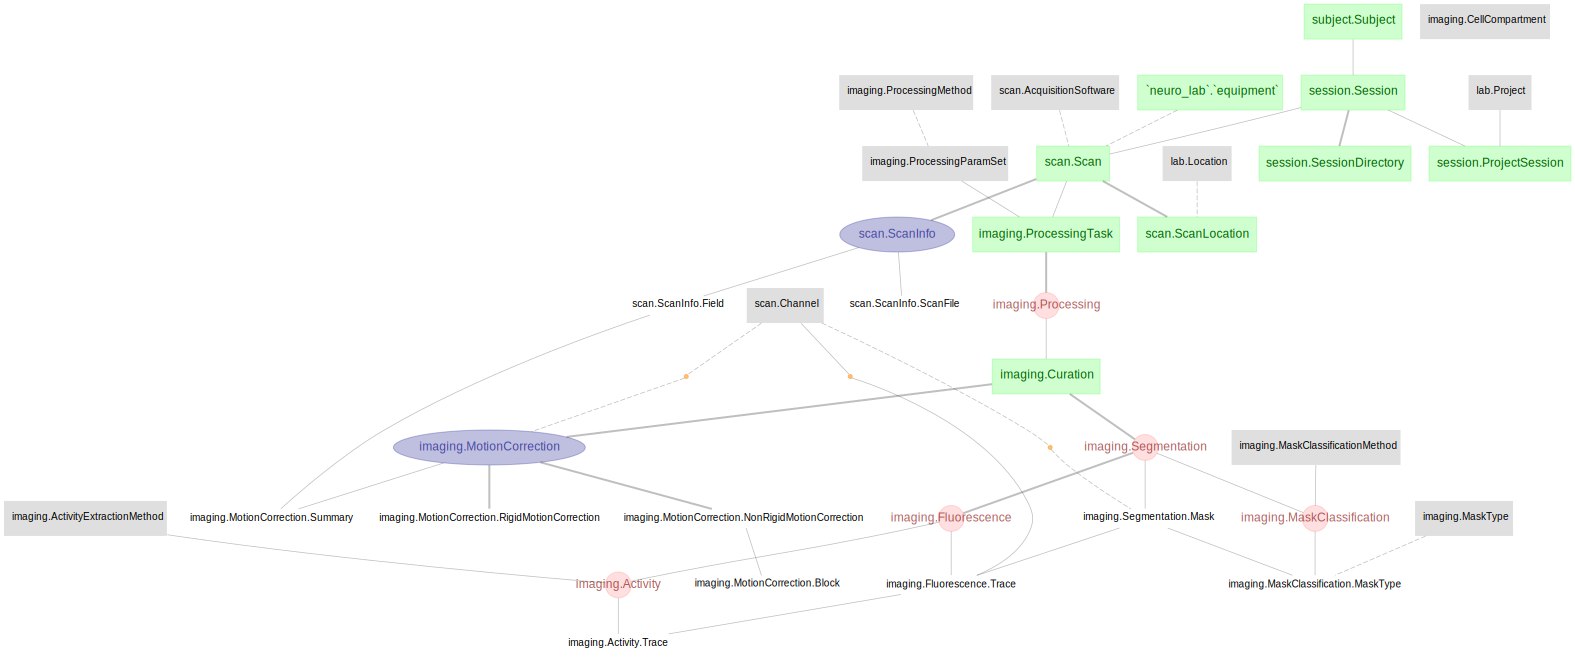

In [3]:
dj.Diagram(imaging) + dj.Diagram(scan) + (dj.Diagram(session.Session) + 1) - 1

## Browsing the data with DataJoint `query` and `fetch` 

+ DataJoint provides functions to query data and fetch.  For a detailed tutorials, visit our [general tutorial site](https://playground.datajoint.io/).

+ Running through the pipeline, we have ingested data of subject3 into the database.

+ Here are some highlights of the important tables.

### `subject.Subject` and `session.Session` tables

In [4]:
subject.Subject()

*subject     sex     subject_birth_ subject_descri
+----------+ +-----+ +------------+ +------------+
subject3     F       2020-01-01     Scanbox acquis
 (Total: 1)

In [5]:
session.Session()

*subject     *session_datet
+----------+ +------------+
subject3     2021-04-30 12:
 (Total: 1)

+ Fetch the primary key for the session of interest which will be used later on in this notebook.

In [5]:
session_key = (session.Session & 'subject = "subject3"').fetch("KEY")[0]

### `scan.Scan` and `scan.ScanInfo` tables

+ These tables stores the scan metadata within a particular session.

In [7]:
scan.Scan & session_key

*subject     *session_datet *scan_id    scanner     acq_software   scan_notes    
+----------+ +------------+ +---------+ +---------+ +------------+ +------------+
subject3     2021-04-30 12: 0           Scanbox     Scanbox                      
 (Total: 1)

In [8]:
scan.ScanInfo & session_key

*subject     *session_datet *scan_id    nfields     nchannels     ndepths     nframes     nrois     x       y       z           fps        bidirectional  usecs_per_line fill_fraction 
+----------+ +------------+ +---------+ +---------+ +-----------+ +---------+ +---------+ +-------+ +-----+ +-----+ +---------+ +--------+ +------------+ +------------+ +------------+
subject3     2021-04-30 12: 0           4           1             4           7530        0         0.0     0.0     -311.71     7.8125     0              nan            nan           
 (Total: 1)

In [9]:
scan.ScanInfo.Field & session_key

*subject     *session_datet *scan_id    *field_idx    px_height     px_width     um_height     um_width     field_x     field_y     field_z     delay_imag roi     
+----------+ +------------+ +---------+ +-----------+ +-----------+ +----------+ +-----------+ +----------+ +---------+ +---------+ +---------+ +--------+ +------+
subject3     2021-04-30 12: 0           0             796           512          nan           nan          0.0         0.0         -108.71     =BLOB=     None    
subject3     2021-04-30 12: 0           1             796           512          nan           nan          0.0         0.0         -56.71      =BLOB=     None    
subject3     2021-04-30 12: 0           2             796           512          nan           nan          0.0         0.0         2.29        =BLOB=     None    
subject3     2021-04-30 12: 0           3             796           512          nan           nan          0.0         0.0         67.29       =BLOB=     None    
 (Total: 4)

### `imaging.ProcessingParamSet`, `imaging.ProcessingTask`, `imaging.Processing`, and `imaging.Curation` tables

+ The parameters used for Suite2p or CaImAn are stored in `imaging.ProcessingParamSet` under a `paramset_idx`.

+ The processing details for Suite2p and CaImAn are stored in `imaging.ProcessingTask` and `imaging.Processing` for the utilized `paramset_idx`.

+ After the motion correction and segmentation, the results may go through a curation process. 
    
    + If it did not go through curation, a copy of the `imaging.ProcessingTask` entry is inserted into `imaging.Curation` with the `curation_output_dir` identical to the `processing_output_dir`.

    + If it did go through a curation, a new entry will be inserted into `imaging.Curation`, with a `curation_output_dir` specified.

    + `imaging.Curation` supports multiple curations of an entry in `imaging.ProcessingTask`.

In [10]:
imaging.ProcessingParamSet()

*paramset_idx  processing_met paramset_desc  param_set_hash params    
+------------+ +------------+ +------------+ +------------+ +--------+
0              suite2p        Calcium imagin be32de46-f21d- =BLOB=    
 (Total: 1)

In [11]:
imaging.ProcessingTask * imaging.Processing & session_key

*subject     *session_datet *scan_id    *paramset_idx  processing_out task_mode     processing_tim package_versio
+----------+ +------------+ +---------+ +------------+ +------------+ +-----------+ +------------+ +------------+
subject3     2021-04-30 12: 0           0              subject3/21010 load          2021-04-30 11:               
 (Total: 1)

In this example workflow, `curation_output_dir` is the same as the `processing_output_dir`, as these results were not manually curated.

In [12]:
imaging.Curation & session_key

*subject     *session_datet *scan_id    *paramset_idx  *curation_id   curation_time  curation_outpu manual_curatio curation_note 
+----------+ +------------+ +---------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
subject3     2021-04-30 12: 0           0              0              2021-04-30 12: subject3/21010 0                            
 (Total: 1)

### `imaging.MotionCorrection` table

+ After processing and curation, results are passed to the `imaging.MotionCorrection` and `imaging.Segmentation` tables.

+ For the example data, the raw data is corrected with rigid and non-rigid motion correction which is stored in `imaging.MotionCorrection.RigidMotionCorrection` and `imaging.MotionCorrection.NonRigidMotionCorrection`, respectively. 

+ Lets first query the information for one curation.

In [13]:
curation_key = (imaging.Curation & session_key & "curation_id=0").fetch1("KEY")

In [14]:
curation_key

{'subject': 'subject3',
 'session_datetime': datetime.datetime(2021, 4, 30, 12, 22, 15, 32000),
 'scan_id': 0,
 'paramset_idx': 0,
 'curation_id': 0}

In [15]:
imaging.MotionCorrection.RigidMotionCorrection & curation_key

*subject     *session_datet *scan_id    *paramset_idx  *curation_id   outlier_fr y_shifts   x_shifts   z_shifts   y_std        x_std      z_std    
+----------+ +------------+ +---------+ +------------+ +------------+ +--------+ +--------+ +--------+ +--------+ +----------+ +--------+ +-------+
subject3     2021-04-30 12: 0           0              0              =BLOB=     =BLOB=     =BLOB=     =BLOB=     0.689302     1.4812     nan      
 (Total: 1)

In [16]:
imaging.MotionCorrection.NonRigidMotionCorrection & curation_key

*subject     *session_datet *scan_id    *paramset_idx  *curation_id   outlier_fr block_height   block_width    block_depth    block_count_y  block_count_x  block_count_z 
+----------+ +------------+ +---------+ +------------+ +------------+ +--------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
subject3     2021-04-30 12: 0           0              0              =BLOB=     128            128            1              6              9              4             
 (Total: 1)

+ For non-rigid motion correction, the details for the individual blocks are stored in `imaging.MotionCorrection.Block`.

In [17]:
imaging.MotionCorrection.Block & curation_key & "block_id=0"

*subject     *session_datet *scan_id    *paramset_idx  *curation_id   *block_id    block_y    block_x    block_z    y_shifts   x_shifts   z_shifts   y_std       x_std       z_std    
+----------+ +------------+ +---------+ +------------+ +------------+ +----------+ +--------+ +--------+ +--------+ +--------+ +--------+ +--------+ +---------+ +---------+ +-------+
subject3     2021-04-30 12: 0           0              0              0            =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     0.95889     1.28989     nan      
 (Total: 1)

+ Summary images are stored in `imaging.MotionCorrection.Summary`

    + Reference image - image used as an alignment template

    + Average image - mean of registered frames

    + Correlation image - correlation map (computed during region of interest \[ROI\] detection)

    + Maximum projection image - max of registered frames

In [18]:
imaging.MotionCorrection.Summary & curation_key & "field_idx=0"

*subject     *session_datet *scan_id    *paramset_idx  *curation_id   *field_idx    ref_image  average_im correlatio max_proj_i
+----------+ +------------+ +---------+ +------------+ +------------+ +-----------+ +--------+ +--------+ +--------+ +--------+
subject3     2021-04-30 12: 0           0              0              0             =BLOB=     =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)

+ Lets fetch the `average_image` and plot it.

In [19]:
average_image = (
    imaging.MotionCorrection.Summary & curation_key & "field_idx=0"
).fetch1("average_image")

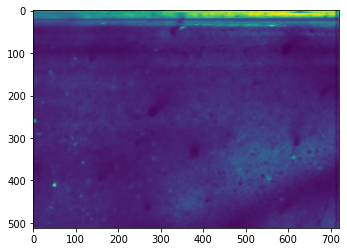

In [20]:
plt.imshow(average_image);

### `imaging.Segmentation` table

+ Lets fetch and plot a mask stored in the `imaging.Segmentation.Mask` table for one `curation_id`.

+ Each mask can be associated with a field by the attribute `mask_center_z`.  For example, masks with `mask_center_z=0` are in the field identified with `field_idx=0` in `scan.ScanInfo.Field`.

In [21]:
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).fetch("mask_xpix", "mask_ypix")

In [22]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

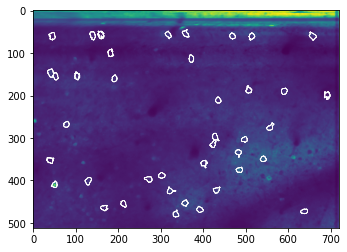

In [23]:
plt.imshow(average_image)
plt.contour(mask_image, colors="white", linewidths=0.5);

### `imaging.MaskClassification` table

+ This table provides the `mask_type` and `confidence` for the mask classification.

In [24]:
imaging.MaskClassification.MaskType & curation_key & "mask=0"

*subject     *session_datet *scan_id    *paramset_idx  *curation_id   *mask_classifi *mask    mask_type     confidence    
+----------+ +------------+ +---------+ +------------+ +------------+ +------------+ +------+ +-----------+ +------------+
subject3     2021-04-30 12: 0           0              0              suite2p_defaul 0        soma          0.977439      
 (Total: 1)

### `imaging.Fluorescence` and `imaging.Activity` tables

+ Lets fetch and plot the flourescence and activity traces for one mask.

In [35]:
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).proj()

In [39]:
fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")  # [Hz]

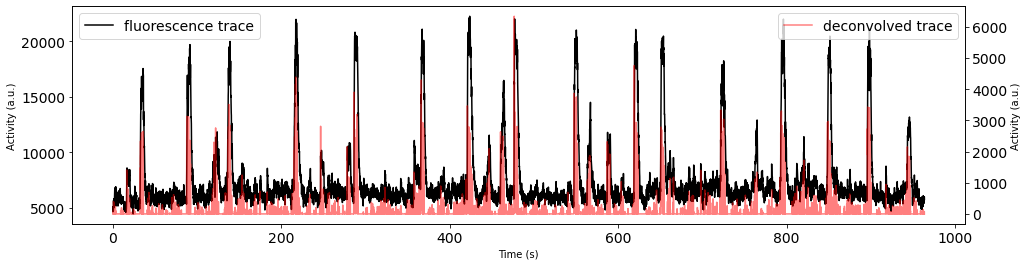

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax2 = ax.twinx()

for f, a in zip(fluorescence_traces, activity_traces):
    ax.plot(np.r_[: f.size] * 1 / sampling_rate, f, "k", label="fluorescence trace")
    ax2.plot(
        np.r_[: a.size] * 1 / sampling_rate,
        a,
        "r",
        alpha=0.5,
        label="deconvolved trace",
    )

    break

ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax.legend(loc="upper left", prop={"size": 14})
ax2.legend(loc="upper right", prop={"size": 14})

ax.set_xlabel("Time (s)")
ax.set_ylabel("Activity (a.u.)")
ax2.set_ylabel("Activity (a.u.)");

## Summary and Next Step

+ This notebook highlights the major tables in the workflow and visualize some of the ingested results. 

+ The next notebook [06-drop](06-drop-optional.ipynb) shows how to drop schemas and tables if needed.

# Drop schemas

+ Schemas are not typically dropped in a production workflow with real data in it. 
+ At the developmental phase, it might be required for the table redesign.
+ When dropping all schemas is needed, the following is the dependency order.

Change into the parent directory to find the `dj_local_conf.json` file. 

In [ ]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [ ]:
from workflow_calcium_imaging.pipeline import *

In [ ]:
# imaging.schema.drop()
# scan.schema.drop()
# session.schema.drop()
# subject.schema.drop()
# lab.schema.drop()